In [14]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [21]:
plt.style.use('../misc/report.mplstyle')
save_dir = "../../../tex/01_regression_resampling/img/"
save=False

MSE = r"\hat\mathcal{E}"
var = r"\widehat{\mathrm{Var}}[\hat f]"
Bias = r"\widehat{\mathrm{Bias}}[\hat f]"
noise = r"\sigma^2"

## Lasso Regression on Franke Function

In [87]:
# Model parameters
degrees = np.arange(1,11)

# Hyperparamters
penalties = np.logspace(np.log10(0.0002),0,100)

# Data parameters
N = 600
sigma=0.1
x,y,z = random_x_y_franke(N, sigma=sigma)

In [88]:
# Resampling
B = 50

prediction_error_bs = np.empty((degrees.shape[0], penalties.shape[0]))
bias = np.empty((degrees.shape[0], penalties.shape[0]))
variance = np.empty((degrees.shape[0], penalties.shape[0]))

for j,penalty in enumerate(tqdm(penalties)):
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=penalty, max_iter=1000000))
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        # We disable shuffling as we want to fit different models to the same trainings data. 
        # Note that random resampling (draw + replace) still takes place
        prediction_error_bs[k,j], bias[k,j], variance[k,j] = \
                predicition_error_bootstrap(squared_error, lasso, X, z, B=B, decomp=True, shuffle=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [144]:
## Rerun cross section at fixed (and not optimal) complexity

p = 6 
X = generate_design_matrix(x, y, p)

# Hyperparamters
penalties_cross = np.logspace(np.log10(0.0002),0,200)

# Resampling
B = 50

# Error components from boostrap (1D)
prediction_error_bs_cross = np.empty(penalties_cross.shape[0])
bias_cross = np.empty(penalties_cross.shape[0])
variance_cross = np.empty(penalties_cross.shape[0])

# Keep track of regression parameter shrinkage
betas = np.empty((penalties_cross.shape[0],X.shape[1] + 1))

for j,penalty in enumerate(tqdm(penalties_cross)):
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=penalty, max_iter=1000000))
    # We disable shuffling as we want to fit different models to the same trainings data. 
    # Note that random resampling (draw + replace) still takes place
    prediction_error_bs_cross[j], bias_cross[j], variance_cross[j] = \
            predicition_error_bootstrap(squared_error, lasso, X, z, B=B, decomp=True, shuffle=False)
    betas[j,0] = lasso.steps[-1][1].intercept_
    betas[j,1:] = lasso.steps[-1][1].coef_

  0%|          | 0/200 [00:00<?, ?it/s]

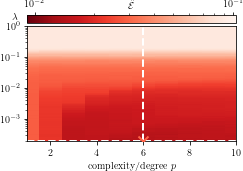

In [122]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

save=True
kwargs = {"lw":2, 
          "cmap":sns.color_palette("Reds_r", as_cmap=True),
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=0.65 * prediction_error_bs[1:,:].min(), 
                                vmax=1.2 * prediction_error_bs[1:,:].max()),
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

idx, idy = np.unravel_index(prediction_error_bs.argmin(), prediction_error_bs.shape)

size = (3.75, 0.618 * 3.75) if save else (10,6)
fig, ax = plt.subplots(figsize=size)

ax.set_yscale("log")
im = ax.pcolormesh(degrees, penalties, prediction_error_bs.T, **kwargs)

ax.scatter(degrees[idx],  penalties[idy], marker="x", color = "tomato",s=100,zorder=10)
ax.set_xlabel(r'complexity/degree $p$')
ax.set_ylabel(r'$\lambda$', rotation=0)
ax.yaxis.set_label_coords(-0.06,1.04)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(rf"${MSE}$")
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,1.9)
ax.axhline(y=penalties[idy], c="w", ls="dashed")
ax.axvline(x=degrees[idx], c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])
plt.show()

if save:
    fig.savefig(save_dir + "lasso_complexity_penalty_MSE_bs.pdf", dpi=600, bbox_inches="tight", pad_inches=0.05)
else:
    plt.show()

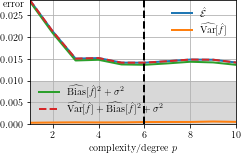

In [121]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)


sns.set_palette("tab10")
mse_line = ax.plot(degrees, prediction_error_bs[:,idy], label=rf"${MSE}$")
var_line = ax.plot(degrees, variance[:,idy], label=rf"${var}$")
bias_line = ax.plot(degrees, bias[:,idy], label=rf"${Bias}^2 + {noise}$")
sum_line = ax.plot(degrees, variance[:,idy] + bias[:,idy], 
                   label=rf"${var} + {Bias}^2 + {noise}$", ls="dashed")

ax.set(xlabel=r"complexity/degree $p$")
ax.set_ylabel(r"error", rotation=0)
ax.yaxis.set_label_coords(-0.08,0.93)

ax.fill_between(degrees, sigma**2, 0, alpha=.3, linewidth=0, color="gray")
ax.axvline(degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")

ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_bs[:,idy])])

ax.legend(*ax.get_legend_handles_labels())
first_legend = ax.legend(handles=[mse_line[0],var_line[0]], loc='upper right')
ax.add_artist(first_legend)
ax.legend(handles=[bias_line[0],sum_line[0]], loc='lower left')
ax.grid(True)

if save:
    fig.savefig(save_dir + "lasso_decomp_complexity.pdf")
else:
    plt.show()

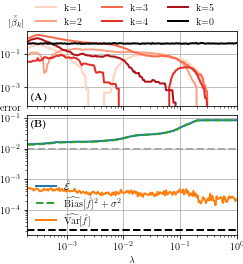

In [148]:
kwargs = {"height_ratios":[0.618,1]}
size = (3.75, 3.75) if save else (10,6)
fig, ax = plt.subplots(nrows=2, figsize=size, sharex=True, gridspec_kw=kwargs)
plt.subplots_adjust(hspace=0.09)

for a in ax:
    a.set_yscale("log")
    a.set_yscale("log")
ax[1].set_xscale("log")

#Smooth betas
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
betas_smooth = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=betas)

# Regression Parameter decay
sns.set_palette("Reds",5)
for k in [1,2,3,4,5]:
     ax[0].plot(penalties_cross, np.abs(betas_smooth[:,k]), label=rf"k={k}")
ax[0].plot(penalties_cross, np.abs(betas[:,0]), c="k", label=rf"k=0")
ax[0].set_ylabel(r"$|\bar{\hat{\beta_k}}|$", rotation=0)
ax[0].yaxis.set_label_coords(-0.05,1.04)
ax[0].legend(*ax[0].get_legend_handles_labels(), loc="lower left", ncol=3, bbox_to_anchor=[0,.95])
ax[0].text(0.02,0.05,r"\textbf{(A)}",ha="left",va="bottom", transform=ax[0].transAxes)

# Error Decomposition
ax[1].plot(penalties_cross, prediction_error_bs_cross, label=rf"${MSE}$", c=mse_line[0].get_color())
ax[1].plot(penalties_cross, bias_cross, label=rf"${Bias}^2 + {noise}$", c=bias_line[0].get_color(), ls="dashed")
ax[1].plot(penalties_cross, variance_cross, label=rf"${var}$", c=var_line[0].get_color())
ax[1].text(0.02,0.88,r"\textbf{(B)}",ha="left",va="bottom", transform=ax[1].transAxes)

ax[1].set(xlabel=r"$\lambda$")
ax[1].set_ylabel(r"error", rotation=0)
ax[1].yaxis.set_label_coords(-0.08,1.02)
ax[1].axhline(y=sigma**2, ls="dashed",color="darkgrey")
ax[1].axhline(y=sigma**2/(0.75 * N), ls="dashed",color="k")

ax[1].legend(*ax[1].get_legend_handles_labels(), loc="lower left")
if save:
    fig.savefig(save_dir + "lasso_decomp_lambda_intercept.pdf", bbox_inches="tight")
else:
    plt.show()

In [115]:
# Model parameters
degrees = np.arange(1,11)

# Hyperparamters
penalties = np.logspace(np.log10(0.0002),0,100)

# Data parameters
N = 600
x,y,z = random_x_y_franke(N)

# Cross Validation
folds = 5

prediction_error_kfold = np.empty((degrees.shape[0], penalties.shape[0]))
prediction_error_kfold_std = np.empty((degrees.shape[0], penalties.shape[0]))

for j,penalty in enumerate(tqdm(penalties)):
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=penalty, max_iter=1000000))
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        prediction_error_kfold[k,j], prediction_error_kfold_std[k,j] = \
            prediction_error_CV(squared_error, lasso, X, z, nfolds=folds)

  0%|          | 0/100 [00:00<?, ?it/s]

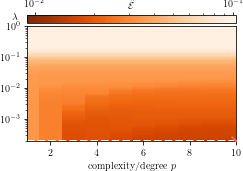

In [116]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

save=True
kwargs = {"lw":2, 
          "cmap":sns.color_palette("Oranges_r", as_cmap=True),
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=0.65 * prediction_error_bs[1:,:].min(), 
                                vmax=1.2 * prediction_error_bs[1:,:].max()),
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

idx_cv, idy_cv = np.unravel_index(prediction_error_kfold.argmin(), prediction_error_kfold.shape)

size = (3.75, 0.618 * 3.75) if save else (10,6)
fig, ax = plt.subplots(figsize=size)

ax.set_yscale("log")
im = ax.pcolormesh(degrees, penalties, prediction_error_kfold.T, **kwargs)
ax.scatter(degrees[idx_cv],  penalties[idy_cv], marker="x", color = "tomato",s=100,zorder=10)
ax.set_xlabel(r'complexity/degree $p$')
ax.set_ylabel(r'$\lambda$', rotation=0)
ax.yaxis.set_label_coords(-0.06,1.04)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(rf"${MSE}$")
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,1.9)
ax.axhline(y=penalties[idy_cv], c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])
plt.show()

if save:
    fig.savefig(save_dir + "lasso_complexity_penalty_MSE_cv.pdf", dpi=600, bbox_inches="tight", pad_inches=0.05)
else:
    plt.show()

[0.0285308  0.02132618 0.01504626 0.01517897 0.01412511 0.01411771
 0.0144552  0.01483383 0.01479268 0.01414953]


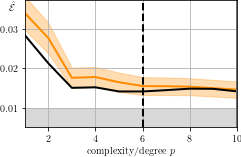

In [123]:
size = (3.8, 0.618 * 3.8) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
line =  ax.plot(degrees, prediction_error_kfold[:,idy_cv], label=rf"${MSE}$", color="darkorange")
ax.plot(degrees, prediction_error_bs[:,idy],  c="k", label=r"boostrap $(B=50)$")
ax.axvline(x=degrees[np.argmin(prediction_error_kfold[:,idy_cv])], c="dimgrey")
ax.axvline(x=degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")

ax.fill_between(degrees, 
                prediction_error_kfold[:,idy_cv]-prediction_error_kfold_std[:,idy_cv], 
               prediction_error_kfold[:,idy_cv]+prediction_error_kfold_std[:,idy_cv], alpha = 0.3, color=line[0].get_color())
ax.fill_between(degrees, sigma**2, 0, alpha=.3, linewidth=0, color="gray")
ax.set_ylim([0.005,1.1*np.max(prediction_error_kfold[:,idy_cv])])
ax.set(xlabel=r"complexity/degree $p$")
ax.set_ylabel(rf"${MSE}$", rotation=0)
ax.yaxis.set_label_coords(-0.06,0.9)

if save:
    fig.savefig(save_dir + "lasso_cross_val.pdf")
else:
    plt.show()

### Model Selection & Model Assessment

In [141]:
# The global minimum in the lambda-p plane (for bootstrap)
idx, idy = np.unravel_index(prediction_error_bs.argmin(), prediction_error_bs.shape)
# The global minimum in the lambda-p plane (for bootstrap)
idx_cv, idy_cv = np.unravel_index(prediction_error_kfold.argmin(), prediction_error_kfold.shape)

lasso_mse_min_bs = prediction_error_bs[idx,idy]
lasso_mse_min_cv = prediction_error_kfold[idx_cv,idy_cv]

lasso_lambdaopt_cv = penalties[idy]
lasso_lambdaopt_bs = penalties[idy_cv]

lasso_popt_cv = degrees[idx_cv]
lasso_popt_bs = degrees[np.argmin(prediction_error_bs[:,idy])]

print(f"Optimal lambda (BS): {lasso_lambdaopt_bs}")
print(f"Optimal p (BS): {lasso_popt_bs}")
print(f"Minimal MSE (bootstrap) = {lasso_mse_min_bs}")
print()
print(f"Optimal lambda (CV): {lasso_lambdaopt_cv}")
print(f"Optimal p (CV): {lasso_popt_cv}")
print(f"Minimal MSE (CV) = {lasso_mse_min_cv} +/- {prediction_error_kfold_std[idx_cv,idy_cv]}")

%store lasso_popt_bs
%store lasso_lambdaopt_bs

Optimal lambda (BS): 0.00020000000000000004
Optimal p (BS): 6
Minimal MSE (bootstrap) = 0.014117709124891995

Optimal lambda (CV): 0.00020000000000000004
Optimal p (CV): 10
Minimal MSE (CV) = 0.014594783622590177 +/- 0.002121422254278716
Stored 'lasso_popt_bs' (int64)
Stored 'lasso_lambdaopt_bs' (float64)


In [142]:
# New unseen test data
Ntest = 200
xtest,ytest,ztest = random_x_y_franke(Ntest, seed=100)
Xtest = generate_design_matrix(xtest, ytest, lasso_popt_bs)

In [143]:
lasso_opt = make_pipeline(StandardScaler(), Lasso(alpha=lasso_lambdaopt_bs, max_iter=1000000))

# Ideal model...
Xtrain = generate_design_matrix(x, y, lasso_popt_bs)

# ...trained on entire train+validate set & tested on new test set
zpred = lasso_opt.fit(Xtrain, z).predict(Xtest)
mse_final = mse(ztest, zpred)
r2_final = lasso_opt.score(Xtest, ztest)
print(f"MSE optimal model: {mse_final}")
print(f"R2-score optimal model: {r2_final}")
%store lasso_opt

MSE optimal model: 0.017659110776681915
R2-score optimal model: 0.7924622173085767
Stored 'lasso_opt' (Pipeline)
